# 带掩码的

<class 'multiagent.MultiAgentAC'>
第0次训练
未加强化学习利润为255092.0,47次未求解
第1次训练
执行时间: 2.7156317234039307 秒,5次未求解，当前强化学习值为924195.0,利润为924195.0
第2次训练
执行时间: 4.827649116516113 秒,0次未求解，当前强化学习值为995869.0,利润为995869.0
第3次训练
执行时间: 5.959773778915405 秒,50次未求解，当前强化学习值为212754.0,利润为212754.0
第4次训练
执行时间: 8.039934635162354 秒,0次未求解，当前强化学习值为1005862.0,利润为1005862.0
第5次训练
执行时间: 9.250344038009644 秒,40次未求解，当前强化学习值为373270.0,利润为373270.0
第6次训练
执行时间: 10.60444188117981 秒,40次未求解，当前强化学习值为372921.0,利润为372921.0
第7次训练
执行时间: 12.48438310623169 秒,22次未求解，当前强化学习值为658220.0,利润为658220.0
第8次训练
执行时间: 13.951624155044556 秒,42次未求解，当前强化学习值为339078.0,利润为339078.0
第9次训练
执行时间: 16.532237768173218 秒,0次未求解，当前强化学习值为1013511.0,利润为1013511.0
第10次训练
执行时间: 18.84442162513733 秒,0次未求解，当前强化学习值为1013966.0,利润为1013966.0
第11次训练
执行时间: 20.112462282180786 秒,48次未求解，当前强化学习值为244140.0,利润为244140.0
第12次训练
执行时间: 21.999542474746704 秒,23次未求解，当前强化学习值为648328.0,利润为648328.0
第13次训练
执行时间: 24.64748239517212 秒,0次未求解，当前强化学习值为1002664.0,利润为1002664.0
第14次训练
执行时间: 27.386648416519165 秒,0次未求解，

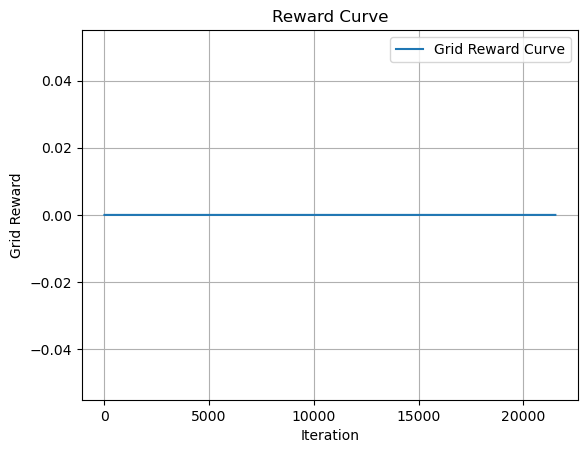

In [3]:
import csv
import numpy as np
from gurobipy import *
from CITY_GRAPH import *
from CITY_NODE import *
from ORDER import *
from VEHICLE import *
from tool_func import *
from Lower_Layer import *
import SETTING
import importlib
import tool_func
from update import *
import os
import time as tm
import copy
from my_env import *
import torch
import multiagent as magent
import matplotlib.pyplot as plt

"""这里是非强化学习部分"""
# 初始化
num_vehicle = 20
num_order = 6
num_city = 8
TIME = 144  # 
CAPACITY = 7
row = [10, 1, 3, 10]
Vehicles = {}
speed = 20 # 之前是20
cancel_penalty = 300
battery_consume = 10
battery_add = 300

matrix = np.tile(row, (num_vehicle, 1))

# 初始化
Vehicles = vehicle_generator(num_vehicle, num_city)
orders_unmatched = {}
G = CityGraph(num_city, 0.3, (10, 30))
name = "navie"
cancel_penalty = 300
order_canceled = 0
Total_order = {}

# 设置s_0
for time in range(TIME):
    Orders = order_generator(num_order, time, num_city-1, CAPACITY, G ,speed)
    for order in Orders.values():
        Total_order[order.id] = order

# 深复制最初的订单与车辆
prim_order = copy.deepcopy(Total_order)
prim_vehicle = copy.deepcopy(Vehicles)
"""这里是强化学习部分"""
# 超参数
STATE_DIM_VEHICLE = 11   # 车辆状态的特征维度
STATE_DIM_ORDER = 12     # 订单状态的特征维度
HIDDEN_DIM = 128         # 隐藏层维度
ACTION_DIM = num_city          # 动作空间维度
ACTOR_LR = 1e-2          # Actor 学习率
CRITIC_LR = 1e-2         # Critic 学习率
GAMMA = 0.99             # 折扣因子
NUM_EPISODES = 300     # 总训练轮数
# 这里也改了
STATE_DIM = 2 *HIDDEN_DIM       
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
agent = magent.MultiAgentAC(
    device = DEVICE,
    VEHICLE_STATE_DIM = STATE_DIM_VEHICLE,
    ORDER_STATE_DIM = STATE_DIM_ORDER, 
    NUM_CITIES = num_city, 
    HIDDEN_DIM = HIDDEN_DIM, 
    STATE_DIM = STATE_DIM
)
print(type(agent))
grid_rewards = []
# 开始计时
start_time = tm.time()

episode_reward = 0
ACTIONS = []
base_revenue = []
first_revnue = []
base_vehicle = []
base_vehicle_class = []
base_order_class = []
base_city_node = []
train_rewards = []
burn_in = 100
batch_time = int(TIME/2)
for episode in range(NUM_EPISODES):
    print(f"第{episode}次训练")
    Total_order = copy.deepcopy(prim_order)
    Vehicles = copy.deepcopy(prim_vehicle)
    objval = 0
    total_objval = 0
    reward = 0
    episode_reward = 0
    invalid_time =  0
    orders_unmatched = {} # 忘记加这个了
    orders_virtual = {}
    
    if episode > 0:
        # agent.load_model(load_path)
        if episode > 1:
            env.time = 0
        
        if episode < burn_in:
            greedy_epsilon = 0.6
            explore = True
        else:
            greedy_epsilon = 0.001
            explore = False
            if episode == burn_in:
                best_model = train_rewards.index(max(train_rewards))
                load_path = f"rl_para/model_checkpoint_{best_model+1}.pth"
                agent = torch.load(load_path,map_location="cpu")
                print(f"最优模型为{best_model}")
                agent.eval()
            if episode > burn_in:
                if train_rewards[best_model] > train_rewards[-1] or first_invalid < invalid_time:
                    agent = torch.load(f'rl_para/model_checkpoint_{best_model+1}.pth',map_location="cpu")
                    print(f"最优模型为{best_model}")
                    agent.eval()
                else:
                    best_model = train_rewards.index(train_rewards[-1]) 
                    agent = torch.load(f'rl_para/model_checkpoint_{best_model+1}.pth',map_location="cpu")
                    print(f"最优模型为{best_model}")
                    agent.eval()
    if_end = False
    for time in range(batch_time):
    
        group = [[], []]
        if time == batch_time -1:
            if_end = True
        # 按时间给出订单
        for order in Total_order.values():
            if order.start_time == time:
                orders_unmatched[order.id] = order
            # 加上这个代码后会导致性能降低
            """
            if order.matched is False:
                order.virtual_departure = order.departure 
            """
        if time != 0 and episode != 0:
            next_vehicle_states = vectorization_vehicle(Vehicles)
            # 改了，不再是total_order
            next_order_states = vectorization_order(orders_unmatched)
            # 这里防止梯度爆炸缩小了reward
            agent.update(vehicle_states, order_states, action,
                         grid_reward, next_vehicle_states, next_order_states , if_end)
            env.time = time
        if time == 0 :
            orders_virtual = orders_unmatched
           
            city_node = city_node_generator(G, orders_virtual, Vehicles, orders_unmatched)
            if episode == 1 :
                env = DispatchEnv(
                    G=G,
                    vehicles=Vehicles,
                    orders=Total_order,
                    cities=city_node,
                    capacity=CAPACITY
                )
            elif episode > 1:
                env.cities = city_node
           
            
        else:
            if episode == 0:
                city_update_without_drl(city_node , Vehicles, orders_unmatched ,time)
            else:
                city_update_without_drl(env.cities , Vehicles, orders_unmatched, time)
            
        if episode != 0:
            
            vehicle_states = vectorization_vehicle(Vehicles)
            # 这里也改了
            order_states = vectorization_order(orders_unmatched)
            
            greedy = random.randint(0, 1)
            if greedy > greedy_epsilon:
                greedy = True
            mask = env.get_mask(orders_unmatched)
            action = agent.take_action_mask(vehicle_states, order_states, mask, explore, greedy)
            reward = env.test_step(orders_unmatched,action)
         
            """
            COUNT = 1000
            max_reward = -999999
            max_action = action
            
           
            while reward != 1000 and COUNT > 0:
                greedy = random.randint(0, 1)
                if greedy > greedy_epsilon:
                    greedy = True
                action = agent.take_action(vehicle_states, order_states, explore, greedy)
                reward = env.test_step(orders_unmatched,action)
                COUNT -= 1
                if reward > max_reward:
                    max_reward = reward
                    max_action = action
            if COUNT == 0:
                reward = env.test_step(orders_unmatched, max_action)
            """
            
           
            
            ACTIONS.append(action) 
            """
            while reward != 0 :
                action = agent.take_action(vehicle_states, order_states)
                reward = env.test_step(orders_unmatched,action)
            
            """
            

        for vehicle in Vehicles.values():
            if vehicle.whether_city:
                group[0].append(vehicle.id)
            else:
                group[1].append(vehicle.id)

        if len(group[0]) != 0:

            if episode == 0:
                temp_Lower_Layer = Lower_Layer(G, city_node, Vehicles, orders_unmatched, name, group, time)
            else:
                temp_Lower_Layer = Lower_Layer(G, env.cities, Vehicles, orders_unmatched, name, group, time)
            try:
                temp_Lower_Layer.get_decision()
                temp_Lower_Layer.constrain_1()
                temp_Lower_Layer.constrain_2()
                temp_Lower_Layer.constrain_3()
                temp_Lower_Layer.constrain_4()
                temp_Lower_Layer.constrain_5()
                temp_Lower_Layer.model.setParam('OutputFlag', 0)
                total_penalty = cancel_penalty * order_canceled
                temp_Lower_Layer.set_objective(matrix)
            
                temp_Lower_Layer.model.optimize()

                if temp_Lower_Layer.model.status == GRB.OPTIMAL:
                    # save_results(temp_Lower_Layer,time)
                    # print("Objective value:", temp_Lower_Layer.model.objVal)
                    objval = temp_Lower_Layer.model.objVal 
                else:
                    temp_Lower_Layer.model.computeIIS()
                    temp_Lower_Layer.model.write('iis.ilp')  # 保存不可行约束
                    # print(f"{time}次，No optimal solution found.")
                    self_update(Vehicles, G)
                    objval = basic_cost(Vehicles, orders_unmatched)
                    
                
                _, var_order = temp_Lower_Layer.get_decision()
                update_var(temp_Lower_Layer, Vehicles, orders_unmatched)
                vehicle_in_city = update_vehicle(Vehicles, battery_consume, battery_add, speed, G)
                order_canceled = order_canceled + update_order(orders_unmatched, time, speed)
            except:
                self_update(Vehicles, G)
               
                order_canceled = order_canceled + update_order(orders_unmatched, time, speed)
                objval = - basic_cost(Vehicles, orders_unmatched)
                invalid_time += 1
            
        else:
            
            self_update(Vehicles, G)
            # print(f"{episode}轮，{time}次，{len(group[1])}辆车不在城市")
            order_canceled = order_canceled + update_order(orders_unmatched, time, speed)
            objval = - basic_cost(Vehicles, orders_unmatched)
            # 利润（如果有）减去新增的取消订单
            
            invalid_time += 1
        objval = objval - update_order(orders_unmatched, time, speed) * cancel_penalty
        if episode != 0: 
            
            # 防止梯度爆炸
            grid_reward =   objval
            grid_rewards.append(reward)
            # print(grid_reward)
            episode_reward += reward + objval
        total_objval += objval

        if episode == 0:
            base_revenue.append(objval)
            base_vehicle.append(copy.deepcopy(group[0]))
            # base_vehicle_class.append(copy.deepcopy(Vehicles))
            # base_order_class.append(copy.deepcopy(Total_order))
            
            base_city_node.append(copy.deepcopy(city_node))
            """
            if episode == 1:
                first_revnue.append(objval)
            """
        else:
            # if base_revenue[time] != objval:
            #    print("base_revenue",time, objval,base_revenue[time])
            # if first_revnue[time] != objval:
            #    print("first_revenue",time, first_revnue[time], objval)
            """ 
            if base_vehicle[time] != group[0]:
                print("vehicle is different", len(base_vehicle[time]), len(group[0]))
            if base_city_node[time] != env.cities:
                print(time, base_city_node[time],"\n", env.cities)
            """
            
        # print(f"{len(orders_unmatched)}订单未被匹配,{order_canceled}订单超时,总利润为{objval},强化学习利润为{reward}")
    end_time = tm.time()
    execution_time = end_time - start_time
    if episode != 0:
        print(f"执行时间: {execution_time} 秒,{invalid_time}次未求解，当前强化学习值为{episode_reward},利润为{total_objval}")
        # torch.save(agent.state_dict(), 'model_checkpoint.pth')
        save_path = f"rl_para/model_checkpoint_{episode}.pth"
        torch.save(agent, save_path)
        train_rewards.append(total_objval)
        first_invalid = invalid_time
    else:
        print(f"未加强化学习利润为{total_objval},{invalid_time}次未求解")
    # grid_rewards.append(0)
    # save_path = f"actor_critic_model{episode}.pth"
    # load_path = f"actor_critic_model{episode}.pth"
    
plt.plot(grid_rewards, label='Grid Reward Curve')
plt.xlabel('Iteration')
plt.ylabel('Grid Reward')
plt.title('Reward Curve')
plt.legend()
plt.grid(True)
plt.show()
# print(find_duplicates_with_positions(ACTIONS))

# 带跳过的

In [1]:
import csv
import numpy as np
from gurobipy import *
from CITY_GRAPH import *
from CITY_NODE import *
from ORDER import *
from VEHICLE import *
from tool_func import *
from Lower_Layer import *
import SETTING
import importlib
import tool_func
from update import *
import os
import time as tm
import copy
from my_env import *
import torch
import multiagent as magent
import matplotlib.pyplot as plt

"""这里是非强化学习部分"""
# 初始化
num_vehicle = 20
num_order = 6
num_city = 8
TIME = 144  # 
CAPACITY = 7
row = [10, 1, 3, 10]
Vehicles = {}
speed = 20 # 之前是20
cancel_penalty = 300
battery_consume = 10
battery_add = 300

matrix = np.tile(row, (num_vehicle, 1))

# 初始化
Vehicles = vehicle_generator(num_vehicle, num_city)
orders_unmatched = {}
G = CityGraph(num_city, 0.3, (10, 30))
name = "navie"
cancel_penalty = 300
order_canceled = 0
Total_order = {}

# 设置s_0
for time in range(TIME):
    Orders = order_generator(num_order, time, num_city-1, CAPACITY, G ,speed)
    for order in Orders.values():
        Total_order[order.id] = order

# 深复制最初的订单与车辆
prim_order = copy.deepcopy(Total_order)
prim_vehicle = copy.deepcopy(Vehicles)
"""这里是强化学习部分"""
# 超参数
STATE_DIM_VEHICLE = 11   # 车辆状态的特征维度
STATE_DIM_ORDER = 12     # 订单状态的特征维度
HIDDEN_DIM = 128         # 隐藏层维度
ACTION_DIM = num_city          # 动作空间维度
ACTOR_LR = 1e-2          # Actor 学习率
CRITIC_LR = 1e-2         # Critic 学习率
GAMMA = 0.99             # 折扣因子
NUM_EPISODES = 300     # 总训练轮数
# 这里也改了
STATE_DIM = 2 *HIDDEN_DIM       
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
agent = magent.MultiAgentAC(
    device = DEVICE,
    VEHICLE_STATE_DIM = STATE_DIM_VEHICLE,
    ORDER_STATE_DIM = STATE_DIM_ORDER, 
    NUM_CITIES = num_city, 
    HIDDEN_DIM = HIDDEN_DIM, 
    STATE_DIM = STATE_DIM
)
print(type(agent))
grid_rewards = []
# 开始计时
start_time = tm.time()

episode_reward = 0
ACTIONS = []
base_revenue = []
first_revnue = []
base_vehicle = []
base_vehicle_class = []
base_order_class = []
base_city_node = []
train_rewards = []
burn_in = 100
batch_time = int(TIME/2)
for episode in range(NUM_EPISODES):
    print(f"第{episode}次训练")
    Total_order = copy.deepcopy(prim_order)
    Vehicles = copy.deepcopy(prim_vehicle)
    objval = 0
    total_objval = 0
    reward = 0
    episode_reward = 0
    invalid_time =  0
    orders_unmatched = {} # 忘记加这个了
    orders_virtual = {}
    
    if episode > 0:
        # agent.load_model(load_path)
        if episode > 1:
            env.time = 0
        
        if episode < burn_in:
            greedy_epsilon = 0.6
            explore = True
        else:
            greedy_epsilon = 0.001
            explore = False
            if episode == burn_in:
                best_model = train_rewards.index(max(train_rewards))
                agent = torch.load(f'model_checkpoint_{best_model+1}.pth',map_location="cpu")
                print(f"最优模型为{best_model}")
                agent.eval()
            if episode > burn_in:
                if train_rewards[best_model] > train_rewards[-1] or first_invalid >= invalid_time:
                    agent = torch.load(f'model_checkpoint_{best_model+1}.pth',map_location="cpu")
                    print(f"最优模型为{best_model}")
                    agent.eval()
                else:
                    best_model = train_rewards.index(train_rewards[-1]) 
                    agent = torch.load(f'model_checkpoint_{best_model+1}.pth',map_location="cpu")
                    print(f"最优模型为{best_model}")
                    agent.eval()
    if_end = False
    for time in range(batch_time):
    
        group = [[], []]
        if time == batch_time -1:
            if_end = True
        # 按时间给出订单
        for order in Total_order.values():
            if order.start_time == time:
                orders_unmatched[order.id] = order
            # 加上这个代码后会导致性能降低
            """
            if order.matched is False:
                order.virtual_departure = order.departure 
            """
        if time != 0 and episode != 0:
            next_vehicle_states = vectorization_vehicle(Vehicles)
            # 改了，不再是total_order
            next_order_states = vectorization_order(orders_unmatched)
            # 这里防止梯度爆炸缩小了reward
            agent.update(vehicle_states, order_states, action,
                         grid_reward, next_vehicle_states, next_order_states , if_end)
            env.time = time
        if time == 0 :
            orders_virtual = orders_unmatched
           
            city_node = city_node_generator(G, orders_virtual, Vehicles, orders_unmatched)
            if episode == 1 :
                env = DispatchEnv(
                    G=G,
                    vehicles=Vehicles,
                    orders=Total_order,
                    cities=city_node,
                    capacity=CAPACITY
                )
            elif episode > 1:
                env.cities = city_node
           
            
        else:
            if episode == 0:
                city_update_without_drl(city_node , Vehicles, orders_unmatched ,time)
            else:
                city_update_without_drl(env.cities , Vehicles, orders_unmatched, time)
            
        if episode != 0:
            
            vehicle_states = vectorization_vehicle(Vehicles)
            # 这里也改了
            order_states = vectorization_order(orders_unmatched)
            
            greedy = random.randint(0, 1)
            if greedy > greedy_epsilon:
                greedy = True
            action = agent.take_action(vehicle_states, order_states, explore, greedy)
            reward = env.test_step(orders_unmatched,action)
            # 一个循环代码让我达到最优
            # 屁股后面的代码是为了让我达到最优
            # 这里是为了让我达到最优
            # 现在放弃了重采样
            """
            COUNT = 1000
            max_reward = -999999
            max_action = action
            
           
            while reward != 1000 and COUNT > 0:
                greedy = random.randint(0, 1)
                if greedy > greedy_epsilon:
                    greedy = True
                action = agent.take_action(vehicle_states, order_states, explore, greedy)
                reward = env.test_step(orders_unmatched,action)
                COUNT -= 1
                if reward > max_reward:
                    max_reward = reward
                    max_action = action
            if COUNT == 0:
                reward = env.test_step(orders_unmatched, max_action)
            """
            
           
            
            ACTIONS.append(action) 
            """
            while reward != 0 :
                action = agent.take_action(vehicle_states, order_states)
                reward = env.test_step(orders_unmatched,action)
            
            """
            

        for vehicle in Vehicles.values():
            if vehicle.whether_city:
                group[0].append(vehicle.id)
            else:
                group[1].append(vehicle.id)

        if len(group[0]) != 0:

            if episode == 0:
                temp_Lower_Layer = Lower_Layer(G, city_node, Vehicles, orders_unmatched, name, group, time)
            else:
                temp_Lower_Layer = Lower_Layer(G, env.cities, Vehicles, orders_unmatched, name, group, time)
            try:
                temp_Lower_Layer.get_decision()
                temp_Lower_Layer.constrain_1()
                temp_Lower_Layer.constrain_2()
                temp_Lower_Layer.constrain_3()
                temp_Lower_Layer.constrain_4()
                temp_Lower_Layer.constrain_5()
                temp_Lower_Layer.model.setParam('OutputFlag', 0)
                total_penalty = cancel_penalty * order_canceled
                temp_Lower_Layer.set_objective(matrix)
            
                temp_Lower_Layer.model.optimize()

                if temp_Lower_Layer.model.status == GRB.OPTIMAL:
                    # save_results(temp_Lower_Layer,time)
                    # print("Objective value:", temp_Lower_Layer.model.objVal)
                    objval = temp_Lower_Layer.model.objVal 
                else:
                    temp_Lower_Layer.model.computeIIS()
                    temp_Lower_Layer.model.write('iis.ilp')  # 保存不可行约束
                    # print(f"{time}次，No optimal solution found.")
                    self_update(Vehicles, G)
                    objval = basic_cost(Vehicles, orders_unmatched)
                    
                
                _, var_order = temp_Lower_Layer.get_decision()
                update_var(temp_Lower_Layer, Vehicles, orders_unmatched)
                vehicle_in_city = update_vehicle(Vehicles, battery_consume, battery_add, speed, G)
                order_canceled = order_canceled + update_order(orders_unmatched, time, speed)
            except:
                self_update(Vehicles, G)
               
                order_canceled = order_canceled + update_order(orders_unmatched, time, speed)
                objval = - basic_cost(Vehicles, orders_unmatched)
                invalid_time += 1
            
        else:
            
            self_update(Vehicles, G)
            # print(f"{episode}轮，{time}次，{len(group[1])}辆车不在城市")
            order_canceled = order_canceled + update_order(orders_unmatched, time, speed)
            objval = - basic_cost(Vehicles, orders_unmatched)
            # 利润（如果有）减去新增的取消订单
            
            invalid_time += 1
        objval = objval - update_order(orders_unmatched, time, speed) * cancel_penalty
        if episode != 0: 
            
            # 防止梯度爆炸
            grid_reward =   objval
            grid_rewards.append(reward)
            # print(grid_reward)
            episode_reward += reward + objval
        total_objval += objval

        if episode == 0:
            base_revenue.append(objval)
            base_vehicle.append(copy.deepcopy(group[0]))
            # base_vehicle_class.append(copy.deepcopy(Vehicles))
            # base_order_class.append(copy.deepcopy(Total_order))
            
            base_city_node.append(copy.deepcopy(city_node))
            """
            if episode == 1:
                first_revnue.append(objval)
            """
        else:
            # if base_revenue[time] != objval:
            #    print("base_revenue",time, objval,base_revenue[time])
            # if first_revnue[time] != objval:
            #    print("first_revenue",time, first_revnue[time], objval)
            """ 
            if base_vehicle[time] != group[0]:
                print("vehicle is different", len(base_vehicle[time]), len(group[0]))
            if base_city_node[time] != env.cities:
                print(time, base_city_node[time],"\n", env.cities)
            """
            
        # print(f"{len(orders_unmatched)}订单未被匹配,{order_canceled}订单超时,总利润为{objval},强化学习利润为{reward}")
    end_time = tm.time()
    execution_time = end_time - start_time
    if episode != 0:
        print(f"执行时间: {execution_time} 秒,{invalid_time}次未求解，当前强化学习值为{episode_reward},利润为{total_objval}")
        # torch.save(agent.state_dict(), 'model_checkpoint.pth')
        torch.save(agent, f"model_checkpoint_{episode}.pth")
        train_rewards.append(total_objval)
        first_invalid = invalid_time
    else:
        print(f"未加强化学习利润为{total_objval},{invalid_time}次未求解")
    # grid_rewards.append(0)
    # save_path = f"actor_critic_model{episode}.pth"
    # load_path = f"actor_critic_model{episode}.pth"
    
plt.plot(grid_rewards, label='Grid Reward Curve')
plt.xlabel('Iteration')
plt.ylabel('Grid Reward')
plt.title('Reward Curve')
plt.legend()
plt.grid(True)
plt.show()
# print(find_duplicates_with_positions(ACTIONS))

<class 'multiagent.MultiAgentAC'>
第0次训练
Set parameter LicenseID to value 2584673


INFO:gurobipy:Set parameter LicenseID to value 2584673


未加强化学习利润为351240.0,48次未求解
第1次训练
执行时间: 1.5951976776123047 秒,66次未求解，当前强化学习值为-316088.0,利润为-1388.0
第2次训练
执行时间: 2.8220858573913574 秒,40次未求解，当前强化学习值为255049.0,利润为471649.0
第3次训练
执行时间: 3.92783522605896 秒,48次未求解，当前强化学习值为76507.0,利润为333107.0
第4次训练
执行时间: 4.801097393035889 秒,60次未求解，当前强化学习值为-187197.0,利润为108603.0
第5次训练
执行时间: 6.016491651535034 秒,45次未求解，当前强化学习值为168199.0,利润为405999.0
第6次训练
执行时间: 6.894177436828613 秒,60次未求解，当前强化学习值为-183913.0,利润为112087.0
第7次训练
执行时间: 7.8495588302612305 秒,60次未求解，当前强化学习值为-186198.0,利润为108602.0
第8次训练
执行时间: 9.370670318603516 秒,43次未求解，当前强化学习值为195294.0,利润为423494.0
第9次训练
执行时间: 10.391007423400879 秒,59次未求解，当前强化学习值为-181762.0,利润为112638.0
第10次训练
执行时间: 11.553189754486084 秒,57次未求解，当前强化学习值为-102270.0,利润为178130.0
第11次训练
执行时间: 13.124795198440552 秒,47次未求解，当前强化学习值为114564.0,利润为361264.0
第12次训练
执行时间: 14.306801080703735 秒,60次未求解，当前强化学习值为-180413.0,利润为112087.0
第13次训练
执行时间: 15.57046389579773 秒,48次未求解，当前强化学习值为68873.0,利润为326673.0
第14次训练
执行时间: 16.64451813697815 秒,57次未求解，当前强化学习值为-110057.0,利润为170643.0
第15次训练


KeyboardInterrupt: 

# ALNS

In [8]:
import numpy as np
from alns import ALNS, State
from alns.accept import SimulatedAnnealing
from alns.stop import MaxIterations
from alns.select import RouletteWheel
import random

# Problem Data
np.random.seed(42)
num_customers = 10
num_vehicles = 3
capacity = 100

# 随机生成坐标和需求
depot = np.array([50, 50])
nodes = np.random.randint(0, 100, (num_customers, 2))
demands = np.random.randint(5, 20, num_customers)

# 计算欧几里得距离
def distance(a, b):
    return np.linalg.norm(a - b)

distance_matrix = np.zeros((num_customers + 1, num_customers + 1))
nodes_full = np.vstack([depot, nodes])  # 加入仓库
for i in range(len(nodes_full)):
    for j in range(len(nodes_full)):
        distance_matrix[i, j] = distance(nodes_full[i], nodes_full[j])

# 初始状态
class VRPState(State):
    def __init__(self, routes):
        self.routes = routes
    
    def objective(self):
        total_cost = sum(
            distance_matrix[route[i], route[i+1]]
            for route in self.routes for i in range(len(route)-1)
        )
        return total_cost
    
    def copy(self):
        return VRPState([route[:] for route in self.routes])

# 破坏算子
def random_removal(state, rng, num_remove=2):
    if isinstance(num_remove, np.random.Generator):  
        num_remove = rng.integers(1, 4)  

    new_state = state.copy()
    for _ in range(num_remove):
        if any(new_state.routes):
            route = random.choice(new_state.routes)
            if len(route) > 2:  # 只有在长度 > 2 时才移除
                idx = rng.integers(1, max(2, len(route) - 1))  # 确保 idx 合法
                route.pop(idx)
    return new_state



# 修复算子
def greedy_insert(state, rng):
    new_state = state.copy()
    unassigned = [i for i in range(1, num_customers + 1) if not any(i in r for r in new_state.routes)]
    for i in unassigned:
        best_cost = float('inf')
        best_route = None
        best_position = None
        for route in new_state.routes:
            for pos in range(1, len(route)):
                temp_route = route[:pos] + [i] + route[pos:]
                cost = sum(distance_matrix[temp_route[j], temp_route[j+1]] for j in range(len(temp_route)-1))
                if cost < best_cost:
                    best_cost, best_route, best_position = cost, route, pos
        if best_route is not None:
            best_route.insert(best_position, i)
    return new_state

# ALNS 运行
initial_routes = [[0, i, 0] for i in range(1, num_customers + 1)]  # 每个客户单独一辆车
initial_state = VRPState(initial_routes)
alns = ALNS()
alns.add_destroy_operator(random_removal)
alns.add_repair_operator(greedy_insert)

# 设定接受准则（模拟退火）
accept = SimulatedAnnealing(1000, 1, 500, method="linear")
select = RouletteWheel([1] * 4, 0.8, 1, 1)
stop = MaxIterations(1000)

result = alns.iterate(initial_state, select, accept, stop)

# 输出最优解
best_state = result.best_state
print("Best routes:", best_state.routes)
print("Best cost:", best_state.objective())

INFO:alns.ALNS:Finished iterating in 0.15s.


Best routes: [[0, 1, 0], [0, 2, 0], [0, 3, 0], [0, 4, 0], [0, 5, 0], [0, 6, 0], [0, 7, 0], [0, 8, 0], [0, 9, 0], [0, 10, 0]]
Best cost: 858.1198159028768
